In [1]:
import os
%load_ext dotenv
%dotenv

import warnings
warnings.filterwarnings('ignore')

In [2]:
! export PYTHONPATH=$TF_DIR:$TF_MODEL_DIR:$TF_MODEL_DIR/slim

# TensorflowモデルをTFLiteにconvertする方法とconvertツールの比較
カスタムのTensorflowのモデルをTFLiteにconvertしようとしてすごく辛かったのではまりどころを記録していく。
サンプルにあるモデルをtfliteにconvertするのはそんなに難しくないんだが、ちょっと自分で手を加えたモデルをconvertしようとしたら初心者の私にはものすごく大変だった。

今回使うのは[tensorflow/modelsのslim](https://github.com/tensorflow/models/tree/master/research/slim)に入ってるモデル。
mobilenet、inception、resnet、vggなどのアーキテクチャが準備されている。
Kerasモデルのconvertはやったことがないので今回の話にはでてこない。

現在最新のTensorflowのversionは2.1(stable)。ただし[tensorflow/models](https://github.com/tensorflow/models/)に準備されているモデルはTensorflow2には対応していない。でもtfliteやtflite_convertに関するドキュメントはほとんど1系対応していない...

※今回書いているPythonコード内のTensorfFlowはすべて2.2、Pythonは3.7.6  
※コマンドラインツールやtocoは明記して別のバージョンを使っている

## TFLiteのモデルにconvertするツールの比較

convertに使うツールいくつか候補がある。  
推奨されてるかどうかではなくて自分が使いやすいと思った順にかいていく 。多分推奨と逆の順番だけど。

### toco
[toco](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/toco)は後述するtflite_convertやPython APIの元になっているプロジェクトで、元になってるだけあってオプションが一番多い。  
自由自在にconvertしたいならこれが一番使いやすかった。

bazel(0.26)で自分でbuildして使う。
これを採用してconvertする方法を後述するので詳細な使い方はそちらで。

### tflite_convert コマンド

tocoをtensorflowがwrapしたコマンドラインツールが[tflite_convert](https://www.tensorflow.org/lite/convert/cmdline)。
tocoとそれほど変わらないが、tensorflowによってオプション名が変わっていたりする気がする。

公式は細かいこと設定したいならtflite_convert使ってねと言っているが、tf2系を入れていると、オプションが少なくて使えない。
このコマンドを使うなら、tf1系の環境を用意したほうが良い。

tflite_convertの[元コード](https://github.com/tensorflow/tensorflow/blob/87663eecd0a67e5fb40e396cdd40bbe5d3649a23/tensorflow/lite/python/tflite_convert.py)を見ると[1系のオプション](https://github.com/tensorflow/tensorflow/blob/87663eecd0a67e5fb40e396cdd40bbe5d3649a23/tensorflow/lite/python/tflite_convert.py#L325)と[2系のオプション](https://github.com/tensorflow/tensorflow/blob/87663eecd0a67e5fb40e396cdd40bbe5d3649a23/tensorflow/lite/python/tflite_convert.py#L509)の違いがよくわかる。

### PythonAPI

ドキュメントに推奨*と書いてある*のが[Python API](https://www.tensorflow.org/lite/convert/python_api)

**v2のtf.lite.TFLiteConverter**

推奨してる方法。saved_modelには対応してるけどfrozen GraphDefs形式の変換には対応していない。

```py
converter = tfv1.lite.from_saved_model(saved_model_path)
converter.convert()
```
でsaved_modelのconvertをできるのでめっちゃ簡単(そうにみえる)。 

でも` tf.compat.v1.lite.TFLiteConverter.from_saved_model`のヘルプを見るとわかるけど
オプション(引数)が以下の3つしかない。
- saved_model_dir
- signature_keys
- tags

オプションが少なすぎて一番使えそうにない。

とくに
- inputのレイヤー・outputのレイヤーが指定
- Quantization-aware training(inference_type、post_training_quantizeなど)のオプション

がないので推奨している割に一番使えない方法だと思う。

**v1のTFLiteConverter(tf.compat.v1.lite.TFLiteConverter)**

Python APIはもとからレイヤーの指定をするオプションがないのかといったらそんなことはなくて[v1のAPI](https://www.tensorflow.org/lite/convert/python_api#1x_%E3%81%8B%E3%82%89_20_%E3%81%B8%E3%81%AE_python_api_%E3%81%AE%E5%A4%89%E6%9B%B4%E7%82%B9%E3%81%BE%E3%81%A8%E3%82%81_)のドキュメントにも書いてあるように、v1APIはv2APIに追加で以下の引数を渡すことができる。

- input_arrays
- input_shapes
- output_arrays

こんなかんじに使える
```py
converter = tf.compat.v1.lite.TFLiteConverter.from_saved_model(
    saved_model_path,
    input_shapes={"input_layer_name": [batch_size, width, height, channel]}
)
converter.convert()
```

## Checkpointからのconvertする

![checkpoint](images/convert_checkpoint.png)

今回は[slim/nets](https://github.com/tensorflow/models/tree/master/research/slim/nets/mobilenet)の中にあるmobilenet_v2のmobilenet_v2_1.0_224_ckptをDLして `<model checkpoint dir>` のパスに格納したとして、tocoを使ってconvertしていく。

slimの実装じゃなくても、GraphDefファイルがあればこの方法で問題ないと思う。

上記データにはfrozenGraphDef(frozen.pb)もtfliteモデルもはいってるけど、カスタムモデルを想定してこれを作るところからやっていく。

### 必要なリポジトリとライブラリのダウンロード

**tensorflow/tensorflow**

- tocoはコマンドとして提供されていないので[tensorflow](https://github.com/tensorflow/tensorflow)をclone。
- **r1.14**のブランチにcheckout
  - それ以前でも良いと思うが、1.15以降はtf.contribの実装がないのでslimのexporter(GraphDefを作るやつ)が動かない。

**tensorflow/models**

slimを使ってるモデルを想定してるのでもう入ってるとは思うけど、[tensorflow/models](https://github.com/tensorflow/models)をcloneする

**bazel**

tocoを使うのにgoogle製のビルドツールbazelを入れる必要がある。
brewとかでは入れないでバイナリから**0.26**をインストールする。
最新のtensorflowはbazel2.0にupgradeされているっぽいけど、上記のtocoを使うには0.26が必要。

[macでのinstall方法](https://docs.bazel.build/versions/master/install-os-x.html#install-with-installer-mac-os-x)

### GraphDefファイルを作る
slimのモデルはGraphDefファイルを作る[exporter](https://github.com/tensorflow/models/blob/master/research/slim/export_inference_graph.py)が実装されてるので、それを使ってexportする。

```sh
cd <tensorflow/models>
python research/slim/export_inference_graph.py \
  --alsologtostderr \
  --model_name=mobilenet_v2 \
  --dataset_name=imagenet \
  --batch_size=1 \
  --image_size=224 \
  --output_file=<model checkpoint dir>/mobilenet_v2_1.0_graph.pb
```

`--model_name`はちがうモデルを指定したならここで対応を確認: [nets_factory.py](https://github.com/tensorflow/models/blob/master/research/slim/nets/nets_factory.py#L42)

### FrozenGraphDefファイルを作る
せっかくカスタムモデルであることを想定しているので、最終層以外にいくつかのレイヤーを取り出すモデルにしてみる。

- ラベルを推論した`MobilenetV2/Predictions/Softmax`
- ラベル推論前の特徴量の`MobilenetV2/Logits/AvgPool2D`

の２つを取り出せるようにfrozenする。
取り出したいレイヤーの名前を確認したいときはGraphDefファイルをnetronで開いてみると良い。

```
cd <tensorflow/tensorflow> 
bazel run tensorflow/python/tools:freeze_graph -- \
  --input_graph=<model checkpoint dir>/mobilenet_v2_1.0_graph.pb \
  --input_checkpoint=<model checkpoint dir>/mobilenet_v2_1.0_224.ckpt \
  --input_binary=true \
  --output_graph=<model checkpoint dir>/mobilenet_v2_1.0_224_frozen.pb \
  --output_node_names=MobilenetV2/Logits/AvgPool2D,MobilenetV2/Predictions/Softmax
```

`tensorflow/python/tools:freeze_graph`のビルドは長くて初回は手元のCPUが12コアあるPCで3時間くらいかかった。

### FrozenGraphDefファイルをTF Liteモデルにコンバート

ここまでできてればあとは簡単

```
cd <tensorflow/tensorflow>
bazel run -c opt tensorflow/lite/toco:toco -- \
    --input_file=<model checkpoint dir>/mobilenet_v2_1.0_224_frozen.pb \
    --input_arrays=input \
    --output_file=<model checkpoint dir>/mobilenet_v2_1.0_224_float32.tflite \
    --output_arrays="MobilenetV2/Logits/AvgPool2D,MobilenetV2/Predictions/Softmax" \
    --inference_type=FLOAT \
    --allow_nonascii_arrays
```

これで完成！

でもこれだとconvertしたもののweightはfloat32でモデルは軽量化されていない。  
TF Liteではfloat16とuint8にもconvertできるのでやってみよう。

uint8(モデルサイズ1/4)にquantizeするには上記コマンドに以下を加える。
```
--post_training_quantize 
```

float16 (モデルサイズが1/2)にするには上記コマンドに以下を加える。
```
--post_training_quantize --quantize_to_float16
```

詳細は[Post-training quantization
](https://www.tensorflow.org/lite/performance/post_training_quantization?hl=ja)のドキュメントへ。

### TF Liteモデルを使って推論

(224, 224, 3)


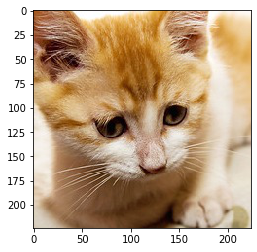

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# image: https://www.flickr.com/photos/kneva/560380352, crop 224, jpg
image = np.array(Image.open('images/test.jpg'))
print(image.shape)

plt.imshow(image)
plt.show()

In [4]:
import pathlib 
import tensorflow as tf
print("tf version:", tf.__version__)

model_path = pathlib.Path(os.environ.get("CHECKPOINT_DIR")) / "mobilenet_v2_1.0_224_float32.tflite"
interpreter = tf.lite.Interpreter(model_path=str(model_path))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# print(input_details)
# print(output_details)
    
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(image, 0).astype(np.float32))
interpreter.invoke()

for output in output_details:
    print("===")
    print(output['name'])
    tensor = interpreter.get_tensor(output['index'])
    print(tensor)

tf version: 2.2.0-dev20200323
===
MobilenetV2/Logits/AvgPool2D
[[[[0.27684855 0.5009162  0.00454296 ... 0.         0.02394939
    0.6504333 ]]]]
===
MobilenetV2/Predictions/Softmax
[[3.4995192e-05 2.3994156e-05 1.5229588e-04 ... 1.8983837e-05
  8.8593506e-06 8.0088567e-04]]


こんなかんじで特徴量とラベルの推論値をTFLiteモデルから取得できた！

　　／⌒ヽ ／⌒ヽ ／⌒ヽ  
⊂ヽ(　^ω^)つ^ω^)つ^ω^)つ  
　 ＼ 　　／　　／　　／  
　　( ＿_フ( ＿_フ( ＿_フ  
　　(／　　(／　　(／  

# さいごに
TFLiteまわりは2系でsupportがまだまだな感じなので、今のところは1系使うのが良さそう。
TensorFlowさん、2系ゴリ押しで2系はドキュメントがあるんだけど1系の情報探そうとするとすごい大変だった・・・。

コンピュータビジョン専門でもないし、普段深層学習モデルをつくる仕事をしているわけでもないので、おかしな部分もあるかもしれないけれど、バージョン周りとか、ツールによるできることの違いとか、知見が色々あったのでせっかくなのでまとめた。


## おまけ

### トラブルシューティング

自分がハマったエラーメモしておく。

#### 解決したやつ
**tfliteにconvertてきたけどグラフが読み込めない**

> input->dims->size != 4 (0 != 4)Node number 0 (CONV_2D) failed to prepare.

今回の場合exportする際に` --batch_size=1 ` を指定しそびれたせいでこのエラーがでた。
GraphDefファイルを作るときにbatch_sizeやinput_tensorを固定しないとこんな感じのエラーがでる。  
TFLiteはinputのTensorをshapeを固定する必要がある。-1のままでは動かない。  

**frozenかexportしようとしたとき**
> ERROR: Linking of rule ‘//tensorflow/python:gen_sparse_ops_py_wrappers_cc’ failed (Exit 1)

bazelのversionがあってないとでた。
bazel含め環境が正しいか確認するにはtensorflowのディレクトリで`./configure`をちゃんとたたいて、自分の環境が間違ってないことを確認しよう。


#### 解決できなかったやつ


**PythonAPI経由でconvertしようとしたとき**  

> Check failed: data_type == DT_FLOAT Fatal Python error: Aborted

で止まってconvertできなかったけど情報量がなさすぎてわからなかった

似てるissue:
- [failed to convert attention-ocr frozen graph to tflite · Issue #35953 · tensorflow/tensorflow](https://github.com/tensorflow/tensorflow/issues/35953)
- [convert exported model to tensorflow lite? · Issue #136 · emedvedev/attention-ocr](https://github.com/emedvedev/attention-ocr/issues/136)


### 超便利ツール
これ本当にfrozen成功してるのかな？  
なんかconvertできたのに動かないなーー？  
っていうのの繰り返しで、そんなときにめちゃくちゃデバッグに役立ったのが[netron](https://github.com/lutzroeder/netron)というグラフの可視化ツール。

![netron](images/netron.png)
↑さっき作ったtfliteファイルもこんな感じにひらける

> Netron supports ONNX (.onnx, .pb, .pbtxt), Keras (.h5, .keras), Core ML (.mlmodel), Caffe (.caffemodel, .prototxt), Caffe2 (predict_net.pb, predict_net.pbtxt), Darknet (.cfg), MXNet (.model, -symbol.json), ncnn (.param) and TensorFlow Lite (.tflite).

とドキュメントにあるように、とにかくいろんな形式のモデルの可視化に対応している。
githubのリポジトリに9kくらいスターついてるし常識ツールなのかもしれないけど、これを知らないがために多大な時間を失った。
今までtensorflowのsession作ったりしながらtensorboardにグラフを出力したりして確認してたけど、そんな事する必要はなかったんだ・・・！

